In [1]:
from kan import KAN, LBFGS
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import numpy as np
from scipy.stats import norm
import pandas as pd

In [16]:
#variable for the BSDE
S = 2
T = 1
t = 0
tau = T-t
K = 5
sigma = 0.13
r = 0.03
x = np.log(S)
X_max = 2*K


In [17]:
dim = 2
np_i = 100 # number of interior points (along each dimension)
np_b = 100 # number of boundary points (along each dimension)
ranges_X = [0, X_max]
ranges_tau = [0,T]


In [18]:
def black_scholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(T)
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    

    return price

In [19]:
model = KAN(width=[2,2,1], grid=5, k=3, grid_eps=1.0, noise_scale=0.25)

checkpoint directory created: ./model
saving model version 0.0


In [20]:
def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)


In [21]:
d1 = lambda x: (x[:, [0]] - np.log(K) + (r + 0.5 * sigma**2) * x[:, [1]]) / (sigma * np.sqrt(x[:, [1]]))
d2 = lambda x: d1(x)-sigma*np.sqrt((x[:, [1]]))
    

In [31]:
# define solution
sol_fun = lambda x: np.exp(x[:, [0]]) * norm.cdf(d1(x)) - K * np.exp(-r * x[:, [1]]) * norm.cdf(d2(x))

source_fun = lambda x:0
x = torch.tensor([[np.log(100), 1], [np.log(110), 0.5]])  # Example initial points



In [32]:
device = "cpu"
sampling_mode = 'random'  # Options: 'random' or 'mesh'
x_mesh = torch.linspace(ranges_X[0], ranges_X[1], steps=np_i)
y_mesh = torch.linspace(ranges_tau[0], ranges_tau[1], steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")

if sampling_mode == 'mesh':
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1, 0)
else:
    x_i = torch.rand((np_i**2, 1), device=device) * (ranges_X[1] - ranges_X[0]) + ranges_X[0]
    y_i = torch.rand((np_i**2, 1), device=device) * (ranges_tau[1] - ranges_tau[0]) + ranges_tau[0]
    x_i = torch.cat([x_i, y_i], dim=1)

# Split into 80% train and 20% test
num_train = int(0.8 * x_i.shape[0])
indices = torch.randperm(x_i.shape[0])

train_indices = indices[:num_train]
test_indices = indices[num_train:]

x_i_train = x_i[train_indices]
x_i_test = x_i[test_indices]

In [33]:
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1, 0)
xb1 = helper(X[0], Y[1])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:, 0], Y[:, 1])
x_b = torch.cat([xb1, xb2, xb3], dim=0)

In [34]:
steps = 50
alpha = 0.01
log = 1

In [29]:

def train():
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='Training')  # Progress bar for training
    for _ in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()
            
            # Compute interior loss using training data
            sol_train = sol_fun(x_i_train)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:, 0, :]
            sol_D1 = sol_D1_fun(x_i_train)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i_train, create_graph=True)[:, :, :]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i_train)
            pde_loss = torch.mean((lap - source)**2)

            # Compute boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred - bc_true)**2)
            
            # Total loss is a weighted sum of PDE loss and boundary loss
            loss = alpha * pde_loss + bc_loss
            loss.backward()  # Backpropagation
            return loss

        if _ % 5 == 0 and _ < 50:
            model.update_grid_from_samples(x_i_train)  # Update grid from samples during training
        
        optimizer.step(closure)  # Perform a single optimization step

        # Evaluate the model on the training data
        sol_train = sol_fun(x_i_train)
        l2_train = torch.mean((model(x_i_train) - sol_train)**2)

        # Optionally, evaluate the model on the test data
        sol_test = sol_fun(x_i_test)
        l2_test = torch.mean((model(x_i_test) - sol_test)**2)

        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2 train: %.2e | l2 test: %.2e" % 
                                 (pde_loss.cpu().detach().numpy(), 
                                  bc_loss.cpu().detach().numpy(), 
                                  l2_train.detach().numpy(),
                                  l2_test.detach().numpy()))

train()


pde loss: 2.35e+08 | bc loss: 1.08e+06 | l2 train: 2.73e+06 | l2 test: 2.40e+06: 100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


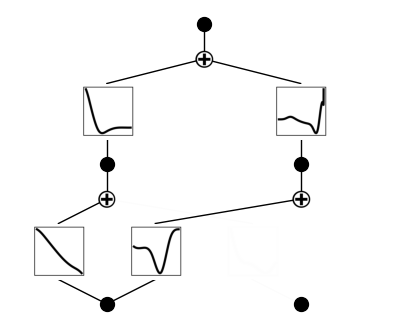

In [30]:
model.plot(beta=10)


In [35]:

for i in range(2):
    for j in range(2):
        model.suggest_symbolic(0,i,j)

for i in range(2):
    model.suggest_symbolic(1,i,0)


  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0      cos    0.999501 -10.941370           2                2   -0.588274
1      sin    0.999501 -10.941201           2                2   -0.588240
2        x    0.987384  -6.307468           1                1   -0.461494
3      x^2    0.997857  -8.859139           2                2   -0.171828
4      exp    0.997281  -8.517420           2                2   -0.103484
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        0    0.000000  0.000014           0                0    0.000003
1        x    0.047580 -0.070315           1                1    0.785937
2      sin    0.804497 -2.354664           2                2    1.129067
3      cos    0.804236 -2.352736           2                2    1.129453
4      x^2    0.636334 -1.459276           2                2    1.308145
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        0    0.000000  0.000014

In [36]:
train()

pde loss: 3.73e+07 | bc loss: 2.36e+05 | l2 train: 6.99e+05 | l2 test: 6.51e+05: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


In [38]:
formula, var = model.symbolic_formula()
formula[0]

96487972443.9997 + 4945.93212890625*exp(-275.353364168069*(0.328136059084201 - 0.000114565110389787*exp(-9.16975211831237*(-x_2 - 0.0638803809346696)**2) + exp(-11.6144623229371*(1 - 0.179366164721365*x_1)**2))**2) - 96489062400.0*exp(-1.13633381881283e-5*(-1 + 0.0190227924540188*exp(-8.34193086920146*(-0.335512202788853*x_2 - 1)**2) + 0.00331602867942593*exp(-0.0399999415874694*(-0.720000718236494*x_1 - 1)**2))**2)

In [39]:
def complex_function(x1, x2):
    term1 = 12396.32324 * np.cosh(
        0.00638 * np.cosh(0.03336 * x1 - 3.90791988372803) + 
        0.00616 * np.cosh(1.20004 * x2 - 0.688) + 1.35846
    )
    
    term2 = 1.12369 * np.cosh(
        0.00046 * np.cosh(0.34632 * x1 - 9.82600021362305) + 
        0.01898 * np.cosh(3.1999980926514 * x2 - 1.68) - 9.7157
    )
    
    result = term1 + term2 - 31222.5589
    
    return result

In [41]:
print(black_scholes(S, K, T, r, sigma))

2.6364825580555117e-13
